In [1]:
"""Methodoogy
FIrstly, I run regression between 00881 TW and 0050 TW with historical data from 2020 to 2024.
Seccondly , I use ridge regression as compensation for conventional OLS regression to conduct simulation for 
00881 TW which has no data before 2020.
Thirdly, I apply data augmentation technique to test with more diverse data by boostrap sampling.
"""

#Package
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [13]:
# Bootstrap Augmentation Function
def bootstrap_samples(X, y, n_samples=1000):
    """Create bootstrap samples with replacement"""
    indices = np.random.randint(0, len(X), size=(n_samples))
    return X[indices], y[indices]

In [14]:

# Read both datasets
file_path_2010 = r'D:\Research_2\0050 and TAIEX since 2010.xlsx'
file_path_00881 = r'D:\Research_2\00881 0050 TAIEX data.xlsx'

# Read data
df_2010 = pd.read_excel(file_path_2010, index_col='Date', parse_dates=True)
df_00881 = pd.read_excel(file_path_00881, index_col='Date', parse_dates=True)


In [15]:
# Calculate returns
returns_2010 = np.log(df_2010/df_2010.shift(1))
returns_00881 = np.log(df_00881/df_00881.shift(1))
returns_2010 = returns_2010.dropna()
returns_00881 = returns_00881.dropna()

In [16]:
# First, get the OLS regression coefficients
X_recent = returns_00881['0050 TW']
y_recent = returns_00881['00881 TW']
X_recent = sm.add_constant(X_recent)
ols_model = sm.OLS(y_recent, X_recent).fit()

# Print OLS regression results
print("\nOLS Regression Parameters:")
print(f"Intercept (β₀) = {ols_model.params[0]:.6f}")
print(f"Slope (β₁) = {ols_model.params[1]:.6f}")
print("\nRegression Equation:")
print(f"00881 TW Returns = {ols_model.params[0]:.6f} + {ols_model.params[1]:.6f} × (0050 TW Returns)")
print("\nFull Regression Results:")
print(ols_model.summary().tables[1])
print("\nOLS R-squared:", round(ols_model.rsquared, 4))


OLS Regression Parameters:
Intercept (β₀) = 0.000006
Slope (β₁) = 0.943550

Regression Equation:
00881 TW Returns = 0.000006 + 0.943550 × (0050 TW Returns)

Full Regression Results:
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.871e-06      0.000      0.033      0.974      -0.000       0.000
0050 TW        0.9435      0.014     67.882      0.000       0.916       0.971

OLS R-squared: 0.8243


C:\Users\user\AppData\Local\Temp\ipykernel_8568\2404398366.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Intercept (β₀) = {ols_model.params[0]:.6f}")
C:\Users\user\AppData\Local\Temp\ipykernel_8568\2404398366.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f"Slope (β₁) = {ols_model.params[1]:.6f}")
C:\Users\user\AppData\Local\Temp\ipykernel_8568\2404398366.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
 

In [17]:
# Prepare data for Ridge regression
X = returns_00881['0050 TW'].values.reshape(-1, 1)
y = returns_00881['00881 TW'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
#Initially, we have OLS: minimize (y - Xβ)²
#Then with ridge: minimize (y - Xβ)² + α∑β²

In [19]:
# First Ridge Model (Without Bootstrap)
scaler_original = StandardScaler()
X_train_scaled_original = scaler_original.fit_transform(X_train)
X_test_scaled_original = scaler_original.transform(X_test)

ridge_model_original = Ridge(alpha=1.0)
ridge_model_original.fit(X_train_scaled_original, y_train)
ridge_pred_original = ridge_model_original.predict(X_test_scaled_original)

# Performance metrics for original model
ridge_r2_original = r2_score(y_test, ridge_pred_original)
ridge_rmse_original = np.sqrt(mean_squared_error(y_test, ridge_pred_original))

print("\nOriginal Ridge Model Performance:")
print(f"R-squared: {ridge_r2_original:.4f}")
print(f"RMSE: {ridge_rmse_original:.6f}")
print(f"Coefficient: {ridge_model_original.coef_[0]:.6f}")
print(f"Intercept: {ridge_model_original.intercept_:.6f}")


Original Ridge Model Performance:
R-squared: 0.7465
RMSE: 0.006832
Coefficient: 0.012225
Intercept: 0.000407


In [20]:
# Ridge Model with Bootstrap
scaler_boot = StandardScaler()
X_train_scaled_boot = scaler_boot.fit_transform(X_train_aug)
X_test_scaled_boot = scaler_boot.transform(X_test)

ridge_model_boot = Ridge(alpha=1.0)
ridge_model_boot.fit(X_train_scaled_boot, y_train_aug)
ridge_pred_boot = ridge_model_boot.predict(X_test_scaled_boot)

# Performance metrics for bootstrap model
ridge_r2_boot = r2_score(y_test, ridge_pred_boot)
ridge_rmse_boot = np.sqrt(mean_squared_error(y_test, ridge_pred_boot))

print("\nBootstrapped Ridge Model Performance:")
print(f"R-squared: {ridge_r2_boot:.4f}")
print(f"RMSE: {ridge_rmse_boot:.6f}")
print(f"Coefficient: {ridge_model_boot.coef_[0]:.6f}")
print(f"Intercept: {ridge_model_boot.intercept_:.6f}")


Bootstrapped Ridge Model Performance:
R-squared: 0.7464
RMSE: 0.006833
Coefficient: 0.011840
Intercept: 0.000886


In [21]:
# Simulate prices for both models
X_full = returns_2010['0050 TW'].values.reshape(-1, 1)

# Original model simulation
X_full_scaled_original = scaler_original.transform(X_full)
ridge_sim_original = ridge_model_original.predict(X_full_scaled_original)

# Bootstrap model simulation
X_full_scaled_boot = scaler_boot.transform(X_full)
ridge_sim_boot = ridge_model_boot.predict(X_full_scaled_boot)

# Convert returns to price levels
ridge_price_original = 100 * np.exp(ridge_sim_original.cumsum())
ridge_price_boot = 100 * np.exp(ridge_sim_boot.cumsum())
actual_0050 = 100 * np.exp(returns_2010['0050 TW'].cumsum())
actual_taiex = 100 * np.exp(returns_2010['TAIEX'].cumsum())


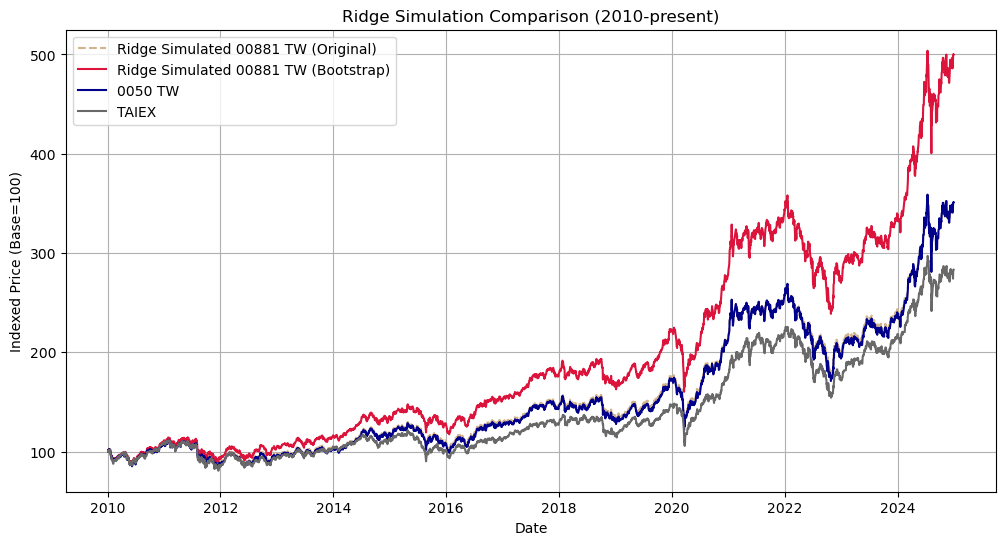

In [23]:
# Plot trend comparisons
plt.figure(figsize=(12, 6))
plt.plot(returns_2010.index, ridge_price_original, color='tan', 
         label='Ridge Simulated 00881 TW (Original)', linestyle='--')
plt.plot(returns_2010.index, ridge_price_boot, color='crimson', 
         label='Ridge Simulated 00881 TW (Bootstrap)')
plt.plot(actual_0050.index, actual_0050, color='darkblue', 
         label='0050 TW')
plt.plot(actual_taiex.index, actual_taiex, color='dimgray', 
         label='TAIEX')
plt.title('Ridge Simulation Comparison (2010-present)')
plt.xlabel('Date')
plt.ylabel('Indexed Price (Base=100)')
plt.legend()
plt.grid(True)
plt.show()

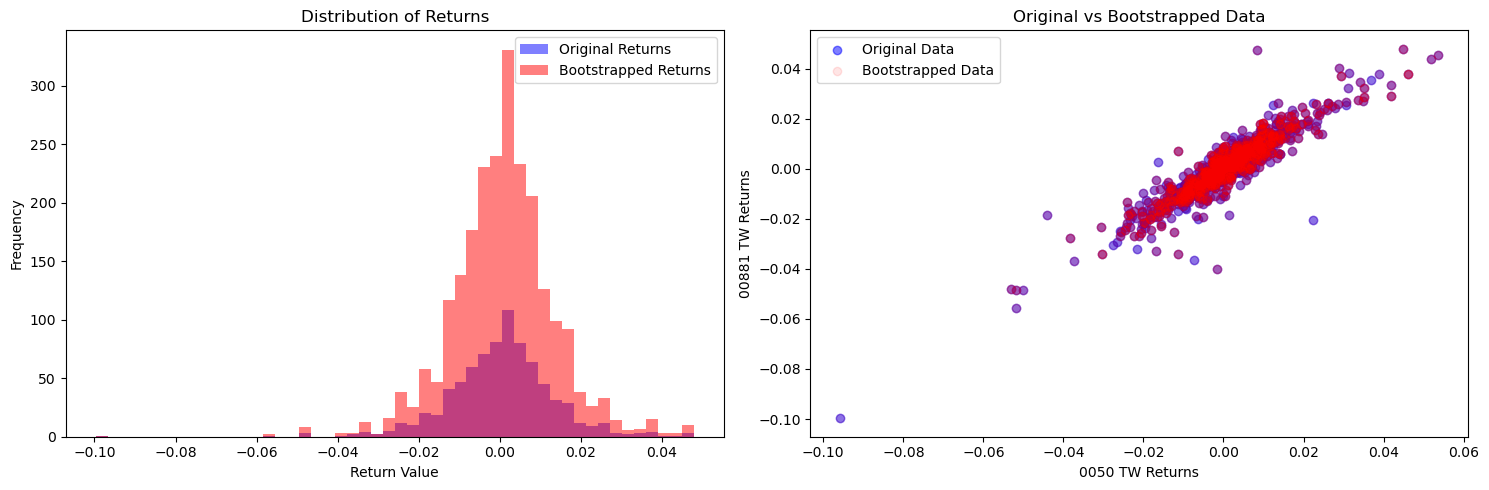

In [24]:
# Distribution and scatter plots
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(y_train, bins=50, alpha=0.5, color='blue', label='Original Returns')
plt.hist(y_train_aug, bins=50, alpha=0.5, color='red', label='Bootstrapped Returns')
plt.title('Distribution of Returns')
plt.xlabel('Return Value')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(X_train, y_train, color='blue', alpha=0.5, label='Original Data')
plt.scatter(X_train_aug, y_train_aug, color='red', alpha=0.1, label='Bootstrapped Data')
plt.xlabel('0050 TW Returns')
plt.ylabel('00881 TW Returns')
plt.title('Original vs Bootstrapped Data')
plt.legend()
plt.tight_layout()
plt.show()

In [25]:
# Compare original vs bootstrap statistics
print("\nComparative Analysis:")
print("Original Data Statistics:")
print(f"Mean: {np.mean(y_train):.6f}")
print(f"Std Dev: {np.std(y_train):.6f}")
print(f"Min: {np.min(y_train):.6f}")
print(f"Max: {np.max(y_train):.6f}")
print("\nBootstrapped Data Statistics:")
print(f"Mean: {np.mean(y_train_aug):.6f}")
print(f"Std Dev: {np.std(y_train_aug):.6f}")
print(f"Min: {np.min(y_train_aug):.6f}")
print(f"Max: {np.max(y_train_aug):.6f}")


Comparative Analysis:
Original Data Statistics:
Mean: 0.000407
Std Dev: 0.013320
Min: -0.099679
Max: 0.047873

Bootstrapped Data Statistics:
Mean: 0.000886
Std Dev: 0.012847
Min: -0.099679
Max: 0.047873
